## PS2: Spam Classification

Author: Tegan Ayers

In [64]:
import os
import re
import glob
import nltk
import email
import string
import warnings
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.tokenize import regexp_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
warnings.filterwarnings('ignore')

### Import Data

In [59]:
def parse_emails(fileDir):
    ''' from a directory of files, read each file and parse the email header and subject '''
    
    files = {'Subject': [], 'Body': []}
    filePaths = glob.glob(fileDir + '/*')
    for file in filePaths[0:-1]:
        with open(file, 'rb') as f:
            msg = email.message_from_bytes(f.read())
    
        # get email headers
        subject = msg.get('Subject')

        # read email's body
        body = str(msg.get_payload())

        # remove HTML tags
        body = BeautifulSoup(body).get_text()
        
        files['Subject'].append(subject)
        files['Body'].append(body)
        
    df = pd.DataFrame.from_dict(files)
    
    return df

# data path
spamPath = os.path.abspath('./spam')
hamPath = os.path.abspath('./easy_ham')

spamDF = parse_emails(spamPath)
hamDF = parse_emails(hamPath)

print('spam shape: ', spamDF.shape)
print('ham shape: ', hamDF.shape)
print()
print('Example Spam DF:')
spamDF.head()

spam shape:  (500, 2)
ham shape:  (2500, 2)

Example Spam DF:


,Subject,Body
0,Life Insurance - Why Pay More?,\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n/TR>\nSave up to...
1,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,1) Fight The Risk of Cancer!\nhttp://www.adcli...
2,Guaranteed to lose 10-12 lbs in 30 days ...,1) Fight The Risk of Cancer!\nhttp://www.adcli...
3,Re: Fw: User Name & Password to Membership To ...,##############################################...
4,[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,I thought you might like these:\n1) Slim Down ...


### Clean Emails

The following actions were completed to clean each email:(1) converted all letters to lowercase, (2) replace urls with "URL", (3) tokenized into words, (4) removed punctuation, and (5) removed english stop words.

The following libraries were used to complete these actions: (1) re, (2) nltk, and (3) string.

There are several ways to tokenize the email. I used a pretty comprehensive split, where words were split at almost any punctuation mark. Therefore, phone numbers, dates and email addresses were each broken into their individual components.

In [60]:
def is_url(word):
    '''function to determine if word is a URL'''
    
    url = re.match("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|"
                     "[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", word)
    return url is not None

def remove_urls(words):
    '''function that changes all urls to "URL" '''
    
    for i, word in enumerate(words):
        if is_url(word):
            words[i] = 'URL'
    return words

def clean_emails(emailCol, target):
    ''' for each email: make all lowercase, replace urls with "URL", tokenize, remove punctuation and stop words'''
    
    # get common puctuation
    punct = string.punctuation

    # get english stopwords
    stopWords = stopwords.words('english')

    # instantiate dictionary
    cleanDataDict = {'Email': [], 'Target': []}

    # loop through all
    for email in emailCol:

        # make all lower case
        email = email.lower()

        # split into words - this is a very basic way of splitting to support removing URLs
        words = email.split()

        # remove URLs
        words = remove_urls(words)

        # now join the words again in order to do a more comprehensive word split using a tokenizer
        email = ' '.join(words)

        # split words using nltk library
        # tokenizer = RegexpTokenizer(r"(?:[a-z][a-z'\-_]+[a-z])|(?:[\w_]+)|(?:\S)")
        # words = [tokenizer.tokenize(s) for s in words]
        # words = wordpunct_tokenize(email)
        words = regexp_tokenize(email, pattern=r"(?:[a-z][a-z'\-_]+[a-z])|(?:[\w_]+)|(?:\S)")

        # remove punctuation
        words_no_punct = [n for n in words if n not in punct]

        # remove stop words
        words_filt = [n for n in words_no_punct if n not in stopWords]

        # add to dict
        cleanDataDict['Email'].append(', '.join(words_filt))
        cleanDataDict['Target'].append(target)
        
    # convert to df
    cleanDF = pd.DataFrame.from_dict(cleanDataDict)
    
    return cleanDF    
        
# get email bodies
hamCol = hamDF['Body']
spamCol = spamDF['Body']

# clean emails
cleanHamDF = clean_emails(hamCol, 0)
cleanSpamDF = clean_emails(spamCol, 1)

# concatenate
allData = cleanHamDF.append(cleanSpamDF, ignore_index=True)

print('Cleaned Dataset:')
allData.head(10)

Cleaned Dataset:


,Email,Target
0,"date, wed, 21, aug, 2002, 10, 54, 46, 0500, ch...",0
1,"martin, posted, tassos, papadopoulos, greek, s...",0
2,"man, threatens, explosion, moscow, thursday, a...",0
3,"klez, virus, die, already, prolific, virus, ev...",0
4,"adding, cream, spaghetti, carbonara, effect, p...",0
5,"jump, carbonara, one, favourites, make, ask, h...",0
6,"scotsman, 22, august, 2002, playboy, wants, go...",0
7,"martin, adamson, wrote, basically, mixture, be...",0
8,"scotsman, thu, 22, aug, 2002, meaningful, sent...",0
9,"trying, research, via, sa, mirrors, search, en...",0


### Word Clouds to Visualize Data

This is one way to determine the most common words in Spam and Ham emails. Some of the most common words in the Spam emails are: slim, life, cancer, fight and risk. Interestingly, the most common words in Ham emails are: man, virus, trying, gianni and URL. I'm not quite sure what to make of that.

Spam Word Cloud:


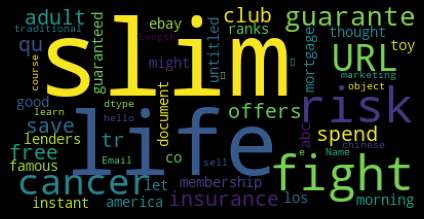

Ham Word Cloud:


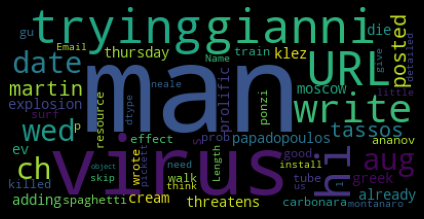

In [20]:
print('Spam Word Cloud:')
spam_wc = WordCloud().generate(str(cleanSpamDF['Email']))
plt.figure(figsize = (6, 6), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout()
plt.show()

print('Ham Word Cloud:')
ham_wc = WordCloud().generate(str(cleanHamDF['Email']))
plt.figure(figsize = (6, 6), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout()
plt.show()

### Train-Test Split

Split the emails into training and test before doing TF-IDF vectorization. An 80-20 split was used.

In [61]:
# split into train, test sets
x_train, x_test, y_train, y_test = train_test_split(allData['Email'], allData['Target'], test_size = 0.2, shuffle=True)

print('X Train Shape: ', x_train.shape)
print('X Test Shape: ', x_test.shape)

# correct types
x_train = x_train.tolist()
x_test = x_test.tolist()
y_train = np.array(y_train)
y_test = np.array(y_test)

X Train Shape:  (2400,)
X Test Shape:  (600,)


### Train & Evaluate Performance

Several models were trained and evaluated including: Multinomial Naive Bayes, KNN, Decision Tree and SVM. Results are summarized in the table below. The code just shows the best model, Logistic Regression.

| Model       | Precision   | Recall    |
| ----------- | ----------- | ----------- |
| Logistic Regresion | 0.953       | 0.950            |
| Decison Tree | 0.940       | 0.930           |
| Multinomial Naive Bayes | 0.887      | 0.870           |
| K Nearest Neighbors | 0.802       | 0.640           |
| Support Vector Classifier | 0.950       | 0.948              |

In [69]:
# setup your pipeline
clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# train
clf.fit(x_train, y_train)

# output scores
print('Train Score: ', clf.score(x_train, y_train))
print('Test Score: ', clf.score(x_test, y_test))
print()

y_pred = clf.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred)
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1score)
print()
print('Confusion Matrix: \n', conf_mat)
print()
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

Train Score:  0.9454166666666667
Test Score:  0.95

Precision:  0.952808988764045
Recall:  0.95
F1 Score:  0.9460929137229716

Confusion Matrix: 
 [[504   0]
 [ 30  66]]

              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       504
        spam       1.00      0.69      0.81        96

    accuracy                           0.95       600
   macro avg       0.97      0.84      0.89       600
weighted avg       0.95      0.95      0.95       600



### Test Set Size

The sklearn function learning_curve was used to adjust the training set size and compare the test error. The test set remained 20% of the data for all training sizes. As expected, the model continued to improve as more training data was added. 

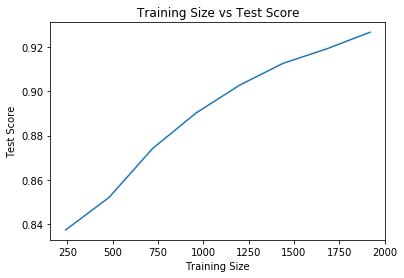

In [71]:
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
train_sizes, _, test_scores, _, _ = learning_curve(clf, allData['Email'], allData['Target'], cv=cv, train_sizes=train_sizes,
                       return_times=True)

plt.plot(train_sizes, np.mean(test_scores, axis=1))
plt.title('Training Size vs Test Score')
plt.xlabel('Training Size')
plt.ylabel('Test Score')
plt.show()

### Top Five Words

The top five most indicative words of spam were found by finding the coefficients of the model with the largest absolute value. These were then correlated to their corresponding feature names. Interestingly, the tokens with the highest coefficient values did not correlate to the words most prominent in the word cloud above. Additionally, the top five tokens were not common words. I'm not quite sure how to interpret this.

In [55]:
# get feature names
feature_names = list(clf['tfidf'].vocabulary_.keys())

# get coefficients associated with each feature
coefs=clf['clf'].coef_[0]

# find top five coefs & which features they belong to
top_five_idx = np.abs(coefs).argsort()[-5:][::-1]
most_indicative_features = [ feature_names[i] for i in top_five_idx]

# print it
print('Most Indicative Tokens: \n', most_indicative_features)

Most Indicative Tokens: 
 ['oz', '2dyyw1pbwl6iodlc2l0bgkgywtzywtsawtsyxigc2vizwjpiglszsbrdwxsyw5pbgft', 'hifnm', 'attractions', 'dtd']
